In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 

import warnings
warnings.filterwarnings('ignore')

In [2]:
folder = os.getcwd() + "/data/tourism/tonga/intermediate/"
filepath = [folder + file for file in os.listdir(folder) if ".csv" in file]

## Load and Merge

In [3]:
tonga = pd.read_csv(filepath[0]).drop("Unnamed: 0", axis=1)
tonga.groupby(by="Year").count()

,Air,Ship,Yacht,Total,date
Year,,,,,
2010,12,12,12,12,12
2011,12,11,12,12,12
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,12,12,12,12,12
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


In [4]:
from scripts.python.PdfParse import check_quality
idxes = check_quality(tonga, ["date", "Year"], "Total")
for idx in idxes:
    combined_strs = str(tonga.iloc[idx, 1]) + str(tonga.iloc[idx, 2])
    combined_num = float(combined_strs)
    if combined_num == float(tonga["Total"][idx]):
        tonga.iloc[idx, 1], tonga.iloc[idx, 2] = combined_num, 0

In [5]:
tonga = (tonga.drop_duplicates().reset_index().drop("index", axis=1))
tonga["date"] = pd.to_datetime(tonga["date"] )
tonga.groupby(by="Year").count()

,Air,Ship,Yacht,Total,date
Year,,,,,
2010,12,12,12,12,12
2011,12,11,12,12,12
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,12,12,12,12,12
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


### Covid

In [6]:
oceania_ci = (pd.read_csv(os.getcwd() + "/data/tourism/oceania_covid_stringency.csv")
                .drop("Unnamed: 0", axis=1))
oceania_ci["date"] = pd.to_datetime(oceania_ci["date"])
oceania_ci.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [7]:
tonga = (tonga.merge(oceania_ci, how="left", on="date")
              .drop(["year", "month"], axis=1)
              .rename({"stringency_index": "covid"}, axis=1)
              .fillna(0))
tonga.head(5)

,Year,Air,Ship,Yacht,Total,date,covid
0,2010,3158,646.0,4.0,3808,2010-01-01,0.0
1,2010,2379,0.0,5.0,2384,2010-02-01,0.0
2,2010,3134,853.0,5.0,3992,2010-03-01,0.0
3,2010,2818,2802.0,30.0,5650,2010-04-01,0.0
4,2010,3670,5303.0,177.0,9150,2010-05-01,0.0


In [8]:
get_adf_df(tonga.diff().dropna(), ["Total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-3.967867,0.001588,9.0,133.0,-3.4805,-2.883528,-2.578496


## SARIMAX

training size : 133, testing size : 11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=482.095, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=485.761, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=442.459, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=483.765, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=443.130, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=444.369, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=442.770, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=442.559, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=444.664, Time=0.40 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=481.084, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=440.863, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=441.012, Time=0.02 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=442.803, Time=0.14 se

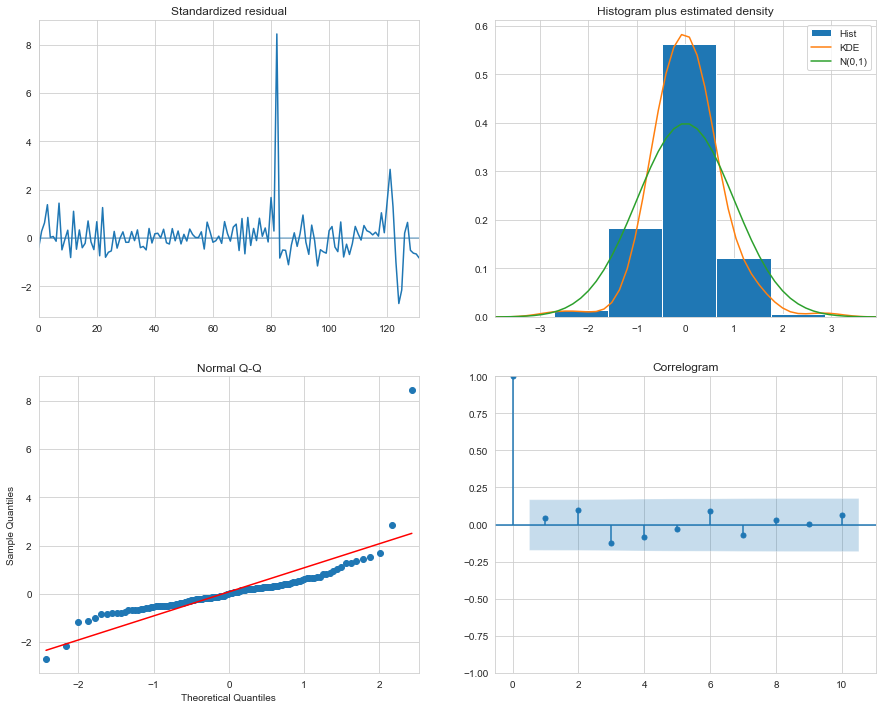

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [9]:
tg = SARIMAXPipeline(data=tonga, y_var="Total", transform_method="scaledlogit",
                     exog_var="covid", training_ratio=0.925)
tg.transform()
tg.stepwise_search()

In [10]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

tg_msres = tg.manual_search(params=all_param)
tg_msres.sort(key=lambda x: x[1])

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:417.09
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:415.17
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:417.06
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:434.2
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:401.68
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:402.95
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:414.84
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:416.02
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:418.0
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:418.18
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:402.96
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:400.83
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:416.54
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:418.0
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:417.64
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:408.26
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:404.96
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:402.78
Tried out SARIMAX(0, 0, 1)x(0, 

Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:398.03
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:395.3
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:414.76
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:415.73
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:414.19
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:407.29
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:399.92
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:397.21
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:441.14
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:440.57
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:442.56
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:463.13
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:419.6
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:421.49
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:440.47
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:440.78
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:442.65
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:445.5
Tried out SARIMAX(1, 1, 0)x(1, 

Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:415.92
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:418.88
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:439.2
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:399.68
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:401.43
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:415.77
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:416.4
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:419.24
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:422.73
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:401.47
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:399.02
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:417.63
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:419.75
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:418.22
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:412.7
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:403.09
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:400.75


In [11]:
tg_models = []
tg_sw = tg.stepwise_model
tg_models.append(pm.ARIMA(
    tg_sw["order"], tg_sw["seasonal_order"],  exog=tg.exog[:tg.training_size]))
for res in tg_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=tg.exog[:tg.training_size])
    tg_models.append(model)

tg_comp = tg.compare_models(
    y=tg.transformed_y[:tg.training_size],
    exog=tg.exog[:tg.training_size],
    models=tg_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [12]:
tg_comp

{'model': [ARIMA(order=(0, 1, 1), seasonal_order=(0, 0, 0, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(0, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 1, 12)),
  ARIMA(order=(0, 0, 2), seasonal_order=(1, 1, 2, 12))],
 'cv_scores': [array([154.05398421,  84.34282634, 199.8871345 ,  84.81353531,
         194.1060445 ,  72.81073997, 145.72659019,  74.49944533,
         142.23564576, 160.26618579, 134.05800778, 149.12749909,
         184.21046021, 139.69505277, 155.86878579, 133.78601078,
          95.32991894, 125.85183359, 200.        ]),
  array([129.57963682, 111.75253503,  95.96125819,  73.76250855,
          48.07406274,  74.9485934 ,  82.48083698,  83.71838468,
          87.85275217, 103.89088116, 137.05197579, 151.53058086,
         151.48338696, 144.27232426, 146.92612131, 162.69124144,
         155.9523769 , 156.51100768, 181.53493128]),
  array([129.57

In [13]:
best_scaled = tg_msres[3][0]
scaled_mod = tg.get_prediction_df(best_scaled, steps=tg.test_size, exog=tg.exog[-tg.test_size:])
scaled_mod.columns.name = None

In [14]:
lower = tonga["Total"].min() - 1
upper = tonga["Total"].max() + 1

for col_idx, col in enumerate(scaled_mod.columns):
    for row_idx, _ in enumerate(scaled_mod[col]):
        scaled_mod.iloc[row_idx, col_idx] = tg.inverse_scaledlogit(
            scaled_mod.iloc[row_idx, col_idx], upper, lower)
        
scaled_mod = pd.concat([tonga[["date", "Total"]], scaled_mod], axis=1)
scaled_mod.head(5)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2010-01-01,3808,6637.500000,NaN,-1.0,NaN,NaN
1,2010-02-01,2384,6637.498786,NaN,-1.0,NaN,NaN
2,2010-03-01,3992,6637.497972,NaN,-1.0,NaN,NaN
3,2010-04-01,5650,6637.499863,NaN,-1.0,NaN,NaN
4,2010-05-01,9150,6637.501444,NaN,-1.0,NaN,NaN


In [15]:
scaled_mod

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2010-01-01,3808,6637.500000,NaN,-1.000000,NaN,NaN
1,2010-02-01,2384,6637.498786,NaN,-1.000000,NaN,NaN
2,2010-03-01,3992,6637.497972,NaN,-1.000000,NaN,NaN
3,2010-04-01,5650,6637.499863,NaN,-1.000000,NaN,NaN
4,2010-05-01,9150,6637.501444,NaN,-1.000000,NaN,NaN
...,...,...,...,...,...,...,...
139,2021-08-01,14,NaN,10034.751301,0.067936,88.064521,8.778765
140,2021-09-01,4,NaN,10035.446453,0.156465,95.501276,9.594709
141,2021-10-01,8,NaN,10055.356353,0.333978,113.767363,11.416073
142,2021-11-01,0,NaN,10059.012773,-0.321534,57.961211,5.336033


Text(0.5, 1.0, "Tonga's Visitor Arrivals")

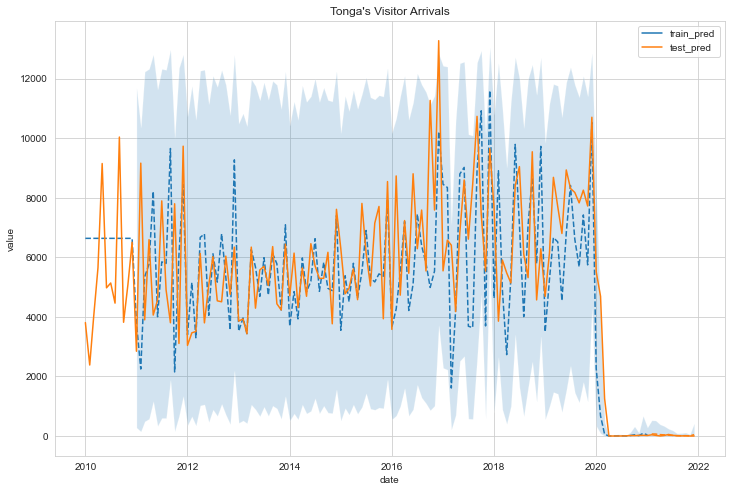

In [16]:
scaled_viz_df = scaled_mod[["date", "train_pred", "test_pred"]].melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="date", y1="mean_ci_lower", y2="mean_ci_upper", data=scaled_mod, alpha=0.2)
sns.lineplot(data=scaled_viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=scaled_mod, x="date", y="Total")
plt.title("Tonga's Visitor Arrivals")

## VARMAX

In [17]:
tg_merged = pd.read_csv(filepath[-1]).drop("Unnamed: 0", axis=1)
tg_merged["date"] = pd.to_datetime(tg_merged["date"])
tg_merged.head(5)

,Year,Month,Number_of_flights_intl,Number_of_flights_total,Seats_arrivals_intl,Seats_arrivals_total,Air,Ship,Yacht,Total,date
0,2019,1,68.0,102.0,14706.0,17698.0,4372,313.0,3.0,4688,2019-01-01
1,2019,2,45.0,80.0,9740.0,11440.0,2709,3448.0,0.0,6157,2019-02-01
2,2019,3,55.0,107.0,10236.0,12662.0,3109,5570.0,7.0,8686,2019-03-01
3,2019,4,53.0,78.0,10615.0,10919.0,4183,3508.0,13.0,7704,2019-04-01
4,2019,5,64.0,87.0,11858.0,12226.0,5166,1506.0,128.0,6800,2019-05-01


## Ratio

In [18]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_tonga.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.head(5)

,date,tonga flights-AU,tonga hotel-AU,tonga travel-AU,tonga flights-NZ,tonga hotel-NZ,tonga travel-NZ,tonga flights-US,tonga hotel-US,tonga travel-US,...,tonga travel-JP,tonga flights-HK,tonga hotel-HK,tonga travel-HK,tonga flights-NC,tonga hotel-NC,tonga travel-NC,tonga flights,tonga hotel,tonga travel
0,2004-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
1,2004-02-01,0,0,0,0,0,0,0,59,0,...,0,0,0,0,0,0,0,2.256111,3.711238,0.000000
2,2004-03-01,79,85,0,0,0,80,100,66,0,...,0,0,0,0,0,0,0,0.000000,0.000000,2.093351
3,2004-04-01,100,0,0,58,90,0,0,0,0,...,0,0,0,0,0,0,0,3.598893,7.354399,0.000000
4,2004-05-01,0,56,81,54,0,0,0,0,0,...,0,0,0,0,0,0,0,2.376195,2.340261,0.000000


In [19]:
tg_merged["ratio"] = tg_merged["Air"]/tg_merged["Seats_arrivals_intl"]
temp = (tg_merged[["date", "ratio"]].merge(oceania_ci, how="left", on="date")
        .drop(["year", "month"], axis=1)
        .fillna(0))
temp["covid"] = temp.date >= "2020-03-12"
temp["quarter"] = temp["date"].dt.quarter
temp = temp.merge(gt[["date", "tonga flights", "tonga travel"]], how="left", on="date")
temp.columns = [col.replace(" ", "_") for col in temp.columns]
temp.head(5)

,date,ratio,stringency_index,covid,quarter,tonga_flights,tonga_travel
0,2019-01-01,0.297294,0.0,False,1,1.075798,0.203206
1,2019-02-01,0.278131,0.0,False,1,0.940670,0.230846
2,2019-03-01,0.303732,0.0,False,1,0.852194,0.268547
3,2019-04-01,0.394065,0.0,False,2,0.793732,0.132975
4,2019-05-01,0.435655,0.0,False,2,0.976347,0.247394


In [20]:
get_adf_df(temp, ["ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
ratio,-0.807989,0.816764,0.0,37.0,-3.620918,-2.943539,-2.6104


In [21]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="ratio ~ covid * stringency_index + C(quarter) + tonga_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.957
Model:                            WLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     95.35
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           9.93e-19
Time:                        16:04:56   Log-Likelihood:                 65.703
No. Observations:                  38   AIC:                            -115.4
Df Residuals:                      30   BIC:                            -102.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3402      0.035      9.829      0.000       0.270       0.411
covid[T.True]                     -0.3766      0.057     -6.568      0.000      -0.494      -0.259
C(quarter)[T.2]                    0.0878      0.026      3.390      0.002       0.035       0.141
C(quarter)[T.3]                    0.1138      0.025      4.534      0.000       0.063       0.165
C(quarter)[T.4]                    0.0803      0.024      3.282      0.003       0.030       0.130
stringency_index                  -0.0045      0.001     -3.661      0.001      -0.007      -0.002
covid[T.True]:stringency_index     0.0032      0.002      1.856      0.073      -0.000       0.007
tonga_travel                       0.0789      0.097      0.815      0.422      -0.119       0.277
==============================================================================
Omnibus:                        4.403   Durbin-Watson:                   1.009
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                3.644
Skew:                           0.758   Prob(JB):                        0.162
Kurtosis:                       3.054   Cond. No.                         719.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

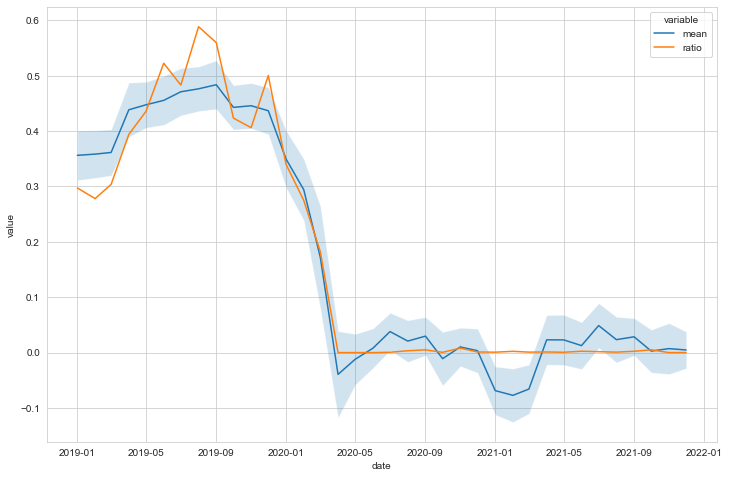

In [22]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)

ratio_viz_df = ratio_stats[["mean", "ratio", "date"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=ratio_stats, x="date", y1="mean_ci_lower",
                y2="mean_ci_upper", alpha=0.2)
plt.show()

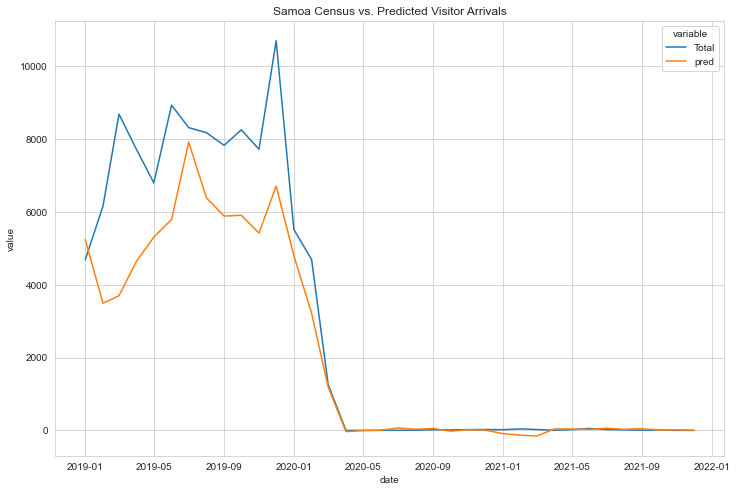

In [23]:
tg_merged["pred"] = ratio_stats["mean"] * tg_merged["Seats_arrivals_intl"]

pred_viz_df = tg_merged[["date", "Total", "pred"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=pred_viz_df, x="date", y="value", hue="variable")
plt.title("Samoa Census vs. Predicted Visitor Arrivals")
plt.show()